In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import os
import datetime
from tensorflow import keras as keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback

2023-08-15 12:16:00.828141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
wandb.init(project="summer2023_nn")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: bibrahim (summer2023_nn). Use `wandb login --relogin` to force relogin


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9216)]
    )
  except RuntimeError as e:
    print(e)

devices = tf.config.list_physical_devices()
print("Available devices:\n", devices)

tf.config.set_visible_devices(gpus[0], "GPU")

logical_gpus = tf.config.experimental.list_logical_devices("GPU")
print("Using GPU:", logical_gpus[0].name)

Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: /device:GPU:0


In [4]:
data = pd.read_csv('./data/train_data_histogram_longtime_210000_coursegrained.csv')

y = data['output_val']
X = data.drop(['output_val'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [5]:
print("X_test:",X_test.shape)
print("X_train:",X_train.shape)

X_test: (419801, 2)
X_train: (1679200, 2)


In [6]:
model = keras.Sequential([
    keras.layers.Normalization(),
    keras.layers.Dense(120, activation='relu', input_shape=(2,)),
    keras.layers.Dropout(0.1),
    keras.layers.Normalization(),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Normalization(),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Normalization(),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Normalization(),
    keras.layers.Dense(1, activation='relu')
])

In [7]:
# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compile the model
# model.compile(optimizer=optimizer, loss='mse', jit_compile=True)
model.compile(optimizer=optimizer, loss='mse')

model.fit(X_train, y_train, callbacks=[WandbCallback()])

epochs = 100  # Number of training iterations
batch_size = 100000  # Number of samples per gradient update

history = model.fit(X_train, y_train, epochs=epochs, callbacks=[WandbCallback()])

val_loss = model.evaluate(X_test, y_test)
print("Validation Loss: ", val_loss)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


52475/52475 [==============================] - 86s 2ms/step - loss: 1.0856
Epoch 1/100
52475/52475 [==============================] - 87s 2ms/step - loss: 0.2655
Epoch 2/100
52475/52475 [==============================] - 87s 2ms/step - loss: 0.2120
Epoch 3/100
52475/52475 [==============================] - 84s 2ms/step - loss: 0.1918
Epoch 4/100
52475/52475 [==============================] - 81s 2ms/step - loss: 0.1790
Epoch 5/100
52475/52475 [==============================] - 74s 1ms/step - loss: 0.1715
Epoch 6/100
52475/52475 [==============================] - 75s 1ms/step - loss: 0.1629
Epoch 7/100
52475/52475 [==============================] - 75s 1ms/step - loss: 0.1563
Epoch 8/100
52475/52475 [==============================] - 75s 1ms/step - loss: 0.1537
Epoch 9/100
52475/52475 [==============================] - 75s 1ms/step - loss: 0.1466
Epoch 10/100
52475/52475 [==============================] - 76s 1ms/step - loss: 0.1450
Epoch 11/100
52475/52475 [============================

wandb: Network error (ConnectionError), entering retry loop.


52475/52475 [==============================] - 105s 2ms/step - loss: 0.0853
Epoch 91/100
52475/52475 [==============================] - 105s 2ms/step - loss: 0.0848
Epoch 92/100
52475/52475 [==============================] - 111s 2ms/step - loss: 0.0853
Epoch 93/100
52475/52475 [==============================] - 110s 2ms/step - loss: 0.0855
Epoch 94/100
52475/52475 [==============================] - 106s 2ms/step - loss: 0.0857
Epoch 95/100
52475/52475 [==============================] - 111s 2ms/step - loss: 0.0840
Epoch 96/100
52475/52475 [==============================] - 101s 2ms/step - loss: 0.0829
Epoch 97/100
52475/52475 [==============================] - 96s 2ms/step - loss: 0.0836
Epoch 98/100
52475/52475 [==============================] - 101s 2ms/step - loss: 0.0837
Epoch 99/100
52475/52475 [==============================] - 111s 2ms/step - loss: 0.0821
Epoch 100/100
13119/13119 [==============================] - 9s 658us/step - loss: 0.1303
Validation Loss:  0.13029576838016

In [14]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

13119/13119 [==============================] - 10s 729us/step - loss: 0.0125
Test loss: 0.012535437010228634
13119/13119 [==============================] - 8s 578us/step


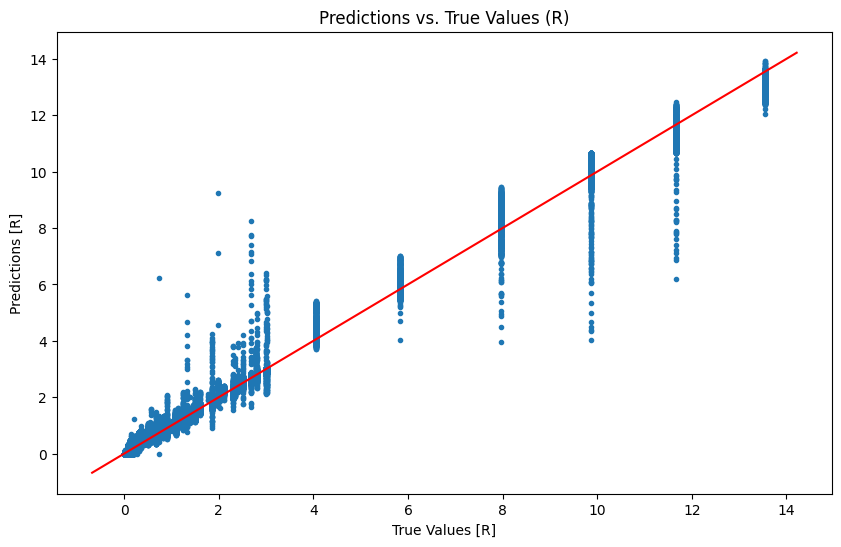

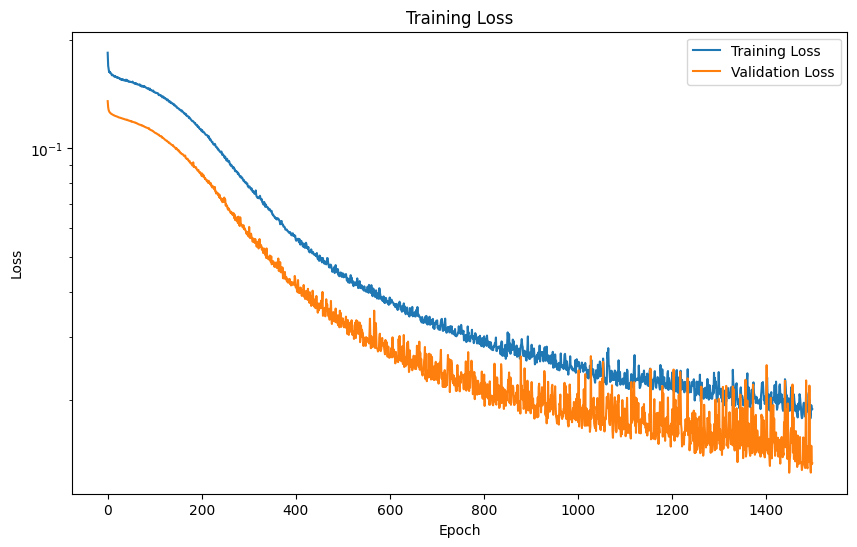

In [15]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(y_test).iloc[:,0], predictions, '.')
# plt.plot(y_test_2d, predictions, '.')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [16]:
# extract U and R from the test data
U_test = X_test.iloc[:,0]
R_test = X_test.iloc[:,1]
output_test = y_test.iloc[:]

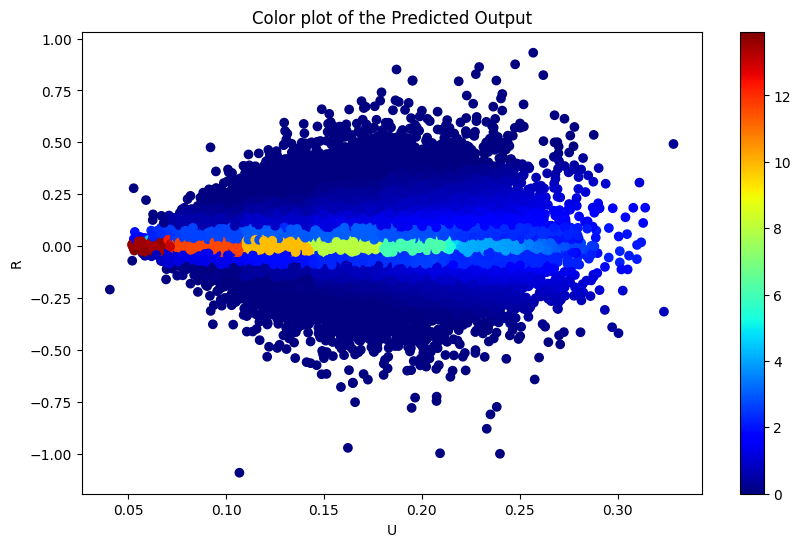

In [17]:
# Make a color plot of the predictions with U_test and R_test as the axes
plt.figure(figsize=(10, 6))
# plt.scatter(U_test, R_test, c=np.log(predictions.reshape(-1)), cmap='jet')
plt.scatter(U_test, R_test, c=predictions.reshape(-1), cmap='jet')
plt.xlabel('U')
plt.ylabel('R')
plt.title('Color plot of the Predicted Output')
plt.colorbar()
plt.show()


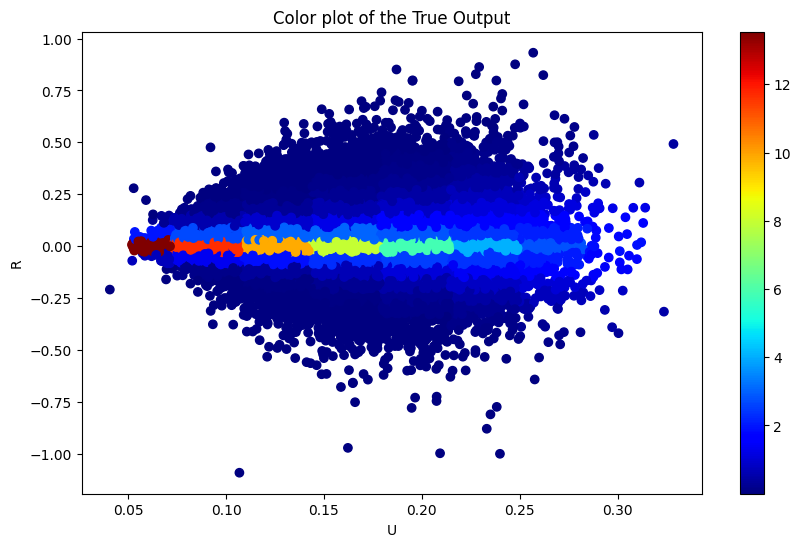

In [18]:
# Make a color plot of the output_test with U_test and R_test as the axes
plt.figure(figsize=(10, 6))
# plt.scatter(U_test, R_test, c=np.log(output_test), cmap='jet')
plt.scatter(U_test, R_test, c=output_test, cmap='jet')
plt.xlabel('U')
plt.ylabel('R')
plt.title('Color plot of the True Output')
plt.colorbar()
plt.show()